Data inporting and setup


In [60]:

'''imports and setting up our plot as well as dataset setup'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn import model_selection

plt.style.use('ggplot')
rcParams['figure.figsize'] = (12,6)

dataset = pd.read_csv("breast_cancer.csv")
# preprocessing of data
dataset.replace('?', -99999, inplace=True)
# get all the data into columns
columns = dataset.columns.tolist()
# remove class and id as they have no effect on the prediction
columns = [c for c in columns if c not in ["Class", "ID"]]
# storing the variable we will prredict with
target = 'Class'

X = dataset[columns]
y = dataset[target]
num_1 = 0
y = y.map({2: 0, 4: 1})
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.7, random_state=0)

In [2]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=72, max_depth=5, min_samples_split=50,
                                       min_samples_leaf=5, subsample=0.8, random_state=10, max_features=3, warm_start=True)
    # learning_rate = determines the impact of each tree on the final outcome, low values preferred to make tree robust but need more trees (n_estimators) to model all the relations
    # n_estimators = number of sequential trees to be modeled, can cause over-fitting so it should be balanced with learning rate
    # max_depth = maximum depth of a tree, higher depth -> more specific -> over-fitting, only ~ 560 samples so low end number 5
    # min_samples_split = minimum number of samples required in a node to be splitted, ~ 0.5-1% of samples
    # min_samples_leaf = minimum number of samples required in a leaf, ~ a 10th of split
    # subsample =  fraction (%) of observations to be selected for each tree, between 0.7 and 1 are good, strengthening values
    # random_state = random number seed so that same random numbers are generated every time, if not fixed -> different outcomes for subsequent runs
    # max_features = number of features to consider while searching for best split, 30-40% of total features, higher value -> CAN cause over-fitting
    # warm_start = fit additional trees on previous fits of a model, can use it to increase the number of estimators in small steps and test different values without having to run from scratch
scoring = ['accuracy', 'precision', 'recall', 'f1']

results = model_selection.cross_validate(
        estimator=gradient_boosting_model, X=X, y=y, cv=5, scoring=scoring, return_train_score=True)
print("Mean Training Accuracy: ", results['train_accuracy'].mean()*100,
          "\nMean Training Precision: ", results['train_precision'].mean(),
          "\nMean Training Recall: ", results['train_recall'].mean(),
          "\nMean Training F1 Score: ", results['train_f1'].mean(),
          "\nMean Validation Accuracy: ", results['test_accuracy'].mean()*100,
          "\nMean Validation Precision: ", results['test_precision'].mean(),
          "\nMean Validation Recall: ", results['test_recall'].mean(),
          "\nMean Validation F1 Score: ", results['test_f1'].mean()
          )
    


Mean Training Accuracy:  98.31919243547149 
Mean Training Precision:  0.9609596423109823 
Mean Training Recall:  0.9916990500863558 
Mean Training F1 Score:  0.9760415668173797 
Mean Validation Accuracy:  95.42651593011306 
Mean Validation Precision:  0.9425372866127584 
Mean Validation Recall:  0.9252551020408163 
Mean Validation F1 Score:  0.9323327327819282


funciton to test the seperate parameters and their results on the train time and precision

In [ ]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param
    
    # Extract information from the cross validation model
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    

    plt.plot(param_values, test_scores, '-', label = 'test')
    plt.ylim(ymin = -0.5, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, '-')
    plt.ylim(ymin = 0.0, ymax = 1.25)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

parameter tests

function to evaluate the models 

In [37]:
from sklearn import metrics
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = metrics.accuracy_score(test_labels,predictions)
    precision = metrics.precision_score(test_labels, predictions)
    f1_score = metrics.f1_score(test_labels, predictions)

    return f1_score

In [62]:
#perform first grid search to tune our learning rate to the number of trees as these are linked

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': np.arange(1,250,10),
    'max_features': np.arange(1,40,5),
    'max_depth': np.arange(1,40,5)
    
}

GBAgrid_model = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(random_state=42), param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, scoring='f1',verbose = 1, return_train_score=True)

GBAgrid_model.fit(x_train,y_train)

print(evaluate(GBAgrid_model, x_test,y_test))

print(GBAgrid_model.best_params_)

scores_of_models = []
base_model = GradientBoostingClassifier(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
scores_of_models.append((base_model.get_params, evaluate(base_model, x_test,y_test)))
scores_of_models.append((GBAgrid_model.best_params_, evaluate(GBAgrid_model, x_test,y_test)))
print(scores_of_models)


Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
0.9411764705882353
{'max_depth': 16, 'max_features': 1, 'n_estimators': 171}
[(<bound method BaseEstimator.get_params of GradientBoostingClassifier(n_estimators=10, random_state=42)>, 0.9290322580645162), ({'max_depth': 16, 'max_features': 1, 'n_estimators': 171}, 0.9411764705882353)]


In [63]:
param_grid = {'n_estimators': np.arange(161,181,1),
'max_depth': np.arange(12,21,1)}

GBAgrid_model = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(max_features=1), param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, scoring='f1',verbose = 1, return_train_score=True)
GBAgrid_model.fit(x_train,y_train)
scores_of_models.append((GBAgrid_model.best_params_, evaluate(GBAgrid_model, x_test,y_test)))
print(scores_of_models)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[(<bound method BaseEstimator.get_params of GradientBoostingClassifier(n_estimators=10, random_state=42)>, 0.9290322580645162), ({'max_depth': 16, 'max_features': 1, 'n_estimators': 171}, 0.9411764705882353), ({'max_depth': 13, 'n_estimators': 164}, 0.948051948051948)]


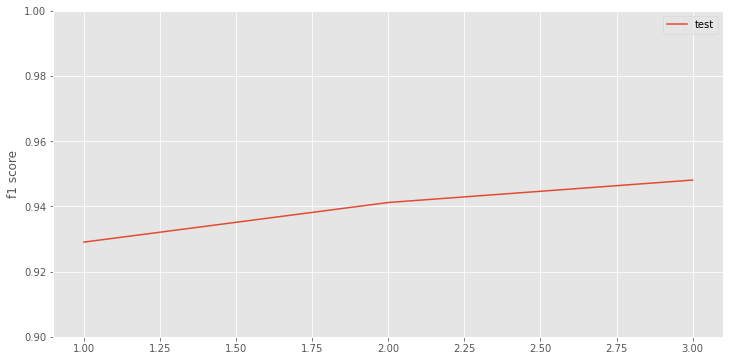

In [64]:
temp_scores = []
for i in scores_of_models:
    temp_scores.append(i[1])
plt.plot([1,2,3], temp_scores, '-', label = 'test')
plt.legend()
plt.ylabel('f1 score')
plt.ylim(ymin = 0.9, ymax = 1)
plt.show()

learning rate

In [76]:
param_grid = {
    'learning_rate': np.arange(0.01,1,0.01)
    
}

GBAgrid_model = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(max_depth= 14,n_estimators= 172,random_state=42, max_features=1), param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, scoring='f1',verbose = 1, return_train_score=True)

GBAgrid_model.fit(x_train,y_train)

print(evaluate(GBAgrid_model, x_test,y_test))

print(GBAgrid_model.best_estimator_.get_params)

scores_of_models = []
base_model = GradientBoostingClassifier(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
scores_of_models.append((base_model.get_params, evaluate(base_model, x_test,y_test)))
scores_of_models.append((GBAgrid_model.best_params_, evaluate(GBAgrid_model, x_test,y_test)))
print(scores_of_models)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
0.9342105263157895
<bound method BaseEstimator.get_params of GradientBoostingClassifier(learning_rate=0.55, max_depth=14, max_features=1,
                           n_estimators=172, random_state=42)>
[(<bound method BaseEstimator.get_params of GradientBoostingClassifier(n_estimators=10, random_state=42)>, 0.9290322580645162), ({'learning_rate': 0.55}, 0.9342105263157895)]


In [77]:
param_grid = {'learning_rate': np.arange(0.4,0.6,0.001),
}

GBAgrid_model = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(max_depth= 14,n_estimators= 172,random_state=42,max_features=1), param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, scoring='f1',verbose = 1, return_train_score=True)
GBAgrid_model.fit(x_train,y_train)
scores_of_models.append((GBAgrid_model.best_params_, evaluate(GBAgrid_model, x_test,y_test)))
print(scores_of_models)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[(<bound method BaseEstimator.get_params of GradientBoostingClassifier(n_estimators=10, random_state=42)>, 0.9290322580645162), ({'learning_rate': 0.55}, 0.9342105263157895), ({'learning_rate': 0.5830000000000002}, 0.9411764705882353)]


In [78]:
param_grid = {'learning_rate': np.arange(0.55,0.6,0.0001),
}

GBAgrid_model = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(max_depth= 14,n_estimators= 172,random_state=42,max_features=1), param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, scoring='f1',verbose = 1, return_train_score=True)
GBAgrid_model.fit(x_train,y_train)
scores_of_models.append((GBAgrid_model.best_params_, evaluate(GBAgrid_model, x_test,y_test)))
print(scores_of_models)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[(<bound method BaseEstimator.get_params of GradientBoostingClassifier(n_estimators=10, random_state=42)>, 0.9290322580645162), ({'learning_rate': 0.55}, 0.9342105263157895), ({'learning_rate': 0.5830000000000002}, 0.9411764705882353), ({'learning_rate': 0.5860999999999961}, 0.948051948051948)]


In [79]:
param_grid = {'learning_rate': np.arange(0.58,0.59,0.00001),
}

GBAgrid_model = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(max_depth= 14,n_estimators= 172,random_state=42,max_features=1), param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, scoring='f1',verbose = 1, return_train_score=True)
GBAgrid_model.fit(x_train,y_train)
scores_of_models.append((GBAgrid_model.best_params_, evaluate(GBAgrid_model, x_test,y_test)))
print(scores_of_models)

Fitting 5 folds for each of 1001 candidates, totalling 5005 fits
[(<bound method BaseEstimator.get_params of GradientBoostingClassifier(n_estimators=10, random_state=42)>, 0.9290322580645162), ({'learning_rate': 0.55}, 0.9342105263157895), ({'learning_rate': 0.5830000000000002}, 0.9411764705882353), ({'learning_rate': 0.5860999999999961}, 0.948051948051948), ({'learning_rate': 0.5841899999999809}, 0.948051948051948)]


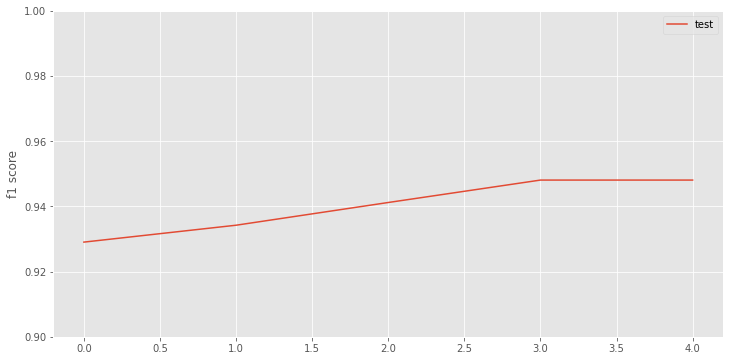

In [80]:
temp_scores = []
for i in scores_of_models:
    temp_scores.append(i[1])
plt.plot(np.arange(len(temp_scores)), temp_scores, '-', label = 'test')
plt.legend()
plt.ylabel('f1 score')
plt.ylim(ymin = 0.9, ymax = 1)
plt.show()

min sample leaf and split

In [109]:
param_grid = {
    'min_samples_split': np.linspace(0.1,0.9,15),
    'min_samples_leaf': np.linspace(0.1,0.9,15)
    
}

GBAgrid_model = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(max_depth= 14,n_estimators= 172,random_state=42, max_features=1, learning_rate=0.5841899999999809, subsample=1), param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, scoring='f1',verbose = 1, return_train_score=True)

GBAgrid_model.fit(x_train,y_train)

print(evaluate(GBAgrid_model, x_test,y_test))

print(GBAgrid_model.best_estimator_.get_params)

scores_of_models = []
base_model = GradientBoostingClassifier(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
scores_of_models.append((base_model.get_params, evaluate(base_model, x_test,y_test)))
scores_of_models.append((GBAgrid_model.best_params_, evaluate(GBAgrid_model, x_test,y_test)))
print(scores_of_models)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
0.9271523178807947
<bound method BaseEstimator.get_params of GradientBoostingClassifier(learning_rate=0.5841899999999809, max_depth=14,
                           max_features=1, min_samples_leaf=0.1,
                           min_samples_split=0.44285714285714284,
                           n_estimators=172, random_state=42, subsample=1)>
[(<bound method BaseEstimator.get_params of GradientBoostingClassifier(n_estimators=10, random_state=42)>, 0.9290322580645162), ({'min_samples_leaf': 0.1, 'min_samples_split': 0.44285714285714284}, 0.9271523178807947)]


In [112]:
param_grid = {
    'min_samples_leaf':np.linspace(0.001,0.2,15),
    'min_samples_split': np.linspace(0.4,1,15)
}

GBAgrid_model = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(max_depth= 14,n_estimators= 172,random_state=42, max_features=1, learning_rate=0.5841899999999809, subsample=1), param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, scoring='f1',verbose = 1, return_train_score=True)
GBAgrid_model.fit(x_train,y_train)
scores_of_models.append((GBAgrid_model.best_params_, evaluate(GBAgrid_model, x_test,y_test)))
print(scores_of_models)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[(<bound method BaseEstimator.get_params of GradientBoostingClassifier(n_estimators=10, random_state=42)>, 0.9290322580645162), ({'min_samples_leaf': 0.1, 'min_samples_split': 0.44285714285714284}, 0.9271523178807947), ({'min_samples_leaf': 0.015214285714285715, 'min_samples_split': 0.4}, 0.9342105263157895), ({'min_samples_leaf': 0.015214285714285715, 'min_samples_split': 0.4}, 0.9342105263157895)]


In [115]:
param_grid = {
    'min_samples_leaf': np.linspace(0.001,0.2,15),
    'min_samples_split': np.linspace(0.3,0.5,15)
}

GBAgrid_model = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(max_depth= 14,n_estimators= 172,random_state=42, max_features=1, learning_rate=0.5841899999999809, subsample=1), param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, scoring='f1',verbose = 1, return_train_score=True)
GBAgrid_model.fit(x_train,y_train)
scores_of_models.append((GBAgrid_model.best_params_, evaluate(GBAgrid_model, x_test,y_test)))
print(scores_of_models)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[(<bound method BaseEstimator.get_params of GradientBoostingClassifier(n_estimators=10, random_state=42)>, 0.9290322580645162), ({'min_samples_leaf': 0.1, 'min_samples_split': 0.44285714285714284}, 0.9271523178807947), ({'min_samples_leaf': 0.015214285714285715, 'min_samples_split': 0.4}, 0.9342105263157895), ({'min_samples_leaf': 0.015214285714285715, 'min_samples_split': 0.4}, 0.9342105263157895), ({'min_samples_leaf': 0.015214285714285715, 'min_samples_split': 0.41428571428571426}, 0.9333333333333333)]


In [116]:
param_grid = {
    'min_samples_leaf': np.linspace(0.01,0.02,15),
    'min_samples_split': np.linspace(0.4,0.45,15)
}

GBAgrid_model = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(max_depth= 14,n_estimators= 172,random_state=42, max_features=1, learning_rate=0.5841899999999809, subsample=1), param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, scoring='f1',verbose = 1, return_train_score=True)
GBAgrid_model.fit(x_train,y_train)
scores_of_models.append((GBAgrid_model.best_params_, evaluate(GBAgrid_model, x_test,y_test)))
print(scores_of_models)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[(<bound method BaseEstimator.get_params of GradientBoostingClassifier(n_estimators=10, random_state=42)>, 0.9290322580645162), ({'min_samples_leaf': 0.1, 'min_samples_split': 0.44285714285714284}, 0.9271523178807947), ({'min_samples_leaf': 0.015214285714285715, 'min_samples_split': 0.4}, 0.9342105263157895), ({'min_samples_leaf': 0.015214285714285715, 'min_samples_split': 0.4}, 0.9342105263157895), ({'min_samples_leaf': 0.015214285714285715, 'min_samples_split': 0.41428571428571426}, 0.9333333333333333), ({'min_samples_leaf': 0.012857142857142857, 'min_samples_split': 0.40714285714285714}, 0.9342105263157895)]


In [125]:
param_grid = {
    'min_samples_leaf': np.linspace(0.01,0.015,15),
    'min_samples_split': np.linspace(0.4,0.42,15)
}

GBAgrid_model = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(max_depth= 14,n_estimators= 172,random_state=42, max_features=1, learning_rate=0.5841899999999809, subsample=1), param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, scoring='f1',verbose = 1, return_train_score=True)
GBAgrid_model.fit(x_train,y_train)
scores_of_models.append((GBAgrid_model.best_params_, evaluate(GBAgrid_model, x_test,y_test)))
print(scores_of_models)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[(<bound method BaseEstimator.get_params of GradientBoostingClassifier(n_estimators=10, random_state=42)>, 0.9290322580645162), ({'max_features': 0.001}, 0.9342105263157895), ({'min_samples_leaf': 0.012857142857142857, 'min_samples_split': 0.40714285714285714}, 0.9342105263157895)]


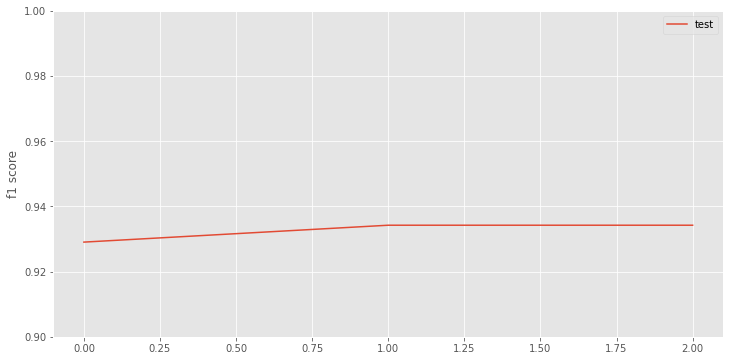

In [126]:
temp_scores = []
for i in scores_of_models:
    temp_scores.append(i[1])
plt.plot(np.arange(len(temp_scores)), temp_scores, '-', label = 'test')
plt.legend()
plt.ylabel('f1 score')
plt.ylim(ymin = 0.9, ymax = 1)
plt.show()

now testing subsample

In [130]:
best = GBAgrid_model.best_estimator_
evaluate(best, x_test,y_test)
evaluate(GradientBoostingClassifier(max_depth= 14,n_estimators= 172,random_state=42, max_features=1, learning_rate=0.5841899999999809, subsample=1).fit(x_train,y_train),x_test,y_test)

0.948051948051948